In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tqdm import tqdm
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = [20,15]

In [2]:
from keras.models import load_model

Using TensorFlow backend.


In [3]:
def draw_box(img, box):
    plt.imshow(img, cmap='Greys_r')
    plt.plot(box[:,0,0],box[:,0,1], 'r-')
    plt.plot(box[::3,0,0],box[::3,0,1], 'r-')
    lr = max(box, key = np.linalg.norm)[0]
    ul = min(box, key = np.linalg.norm)[0]
    plt.scatter([ul[0],lr[0]],[ul[1],lr[1]])

In [4]:
bills = !ls ./bills_for_recognition/

In [5]:
imread = lambda x: cv2.resize(cv2.imread(x), (960,1280))[:,:,::-1]

In [6]:
X = [imread('./bills_for_recognition/'+i) for i in tqdm(bills)]

100%|██████████| 169/169 [00:08<00:00, 20.78it/s]


In [7]:
x_inp = np.r_[[cv2.resize(x,(240,320)) for x in X]].astype('float32')/255

In [8]:
model = load_model('./unet_model.hdf5')

In [9]:
Y = model.predict(x_inp, batch_size=10, verbose=True)[:,:,:,0]

169/169 [==============================] - 20s    


In [10]:
def get_hline(pts):
    lines = np.hstack([pts, np.roll(pts, 1, axis=0)])
    hidx = np.argmin(np.abs(lines[:, 1] - lines[:, 3]))
    hline = lines[hidx].reshape(2,2)
    vec = hline[0] - hline[1]
    if vec[0] < 0:
        vec = - vec
    return vec if vec[0] > 0 else -vec

In [11]:
def process(x,y):
    img = (y>0.9).astype('uint8')*255

    img, contours, _ = cv2.findContours(img, 1, 2)
    cnt = max(contours, key = cv2.contourArea)
    rect = cv2.minAreaRect(cnt)
    points = cv2.boxPoints(rect)
    x_c, y_c = rect[0]

    vec = get_hline(points)
    angle = np.arctan(vec[1]/vec[0]) / np.pi * 180
    
    rows, cols, _ = x.shape
    center_big = tuple( np.r_[x_c,y_c]*x.shape[0]/y.shape[0] )

    M = cv2.getRotationMatrix2D(center_big,angle,1)
    
    dsize = x.shape[:2][::-1]
    x_img = cv2.warpAffine(x,M,dsize)
    mask = cv2.resize(img/255,dsize)
    mask = cv2.warpAffine(mask[:,:,np.newaxis], M, dsize)

    mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,np.ones((5,25)),iterations=5)
    mask = cv2.morphologyEx(mask,cv2.MORPH_OPEN,np.ones((5,5)),iterations=5)

    x_img = x_img[:,:,0]*mask


    x_min = min(np.argwhere(x_img.sum(axis=0)>0))[0]
    x_max = max(np.argwhere(x_img.sum(axis=0)>0))[0]
    y_min = min(np.argwhere(x_img.sum(axis=1)>0))[0]
    y_max = max(np.argwhere(x_img.sum(axis=1)>0))[0]

    x_crop = x_img[y_min:y_max,x_min:x_max]
    x_crop[x_crop < 5] = 0
    
    dsize = (int(x_crop.shape[0] * 300 / x_crop.shape[1]), 300)
    return cv2.resize(x_crop, dsize[::-1])

In [12]:
i=1

In [13]:
i = i-2

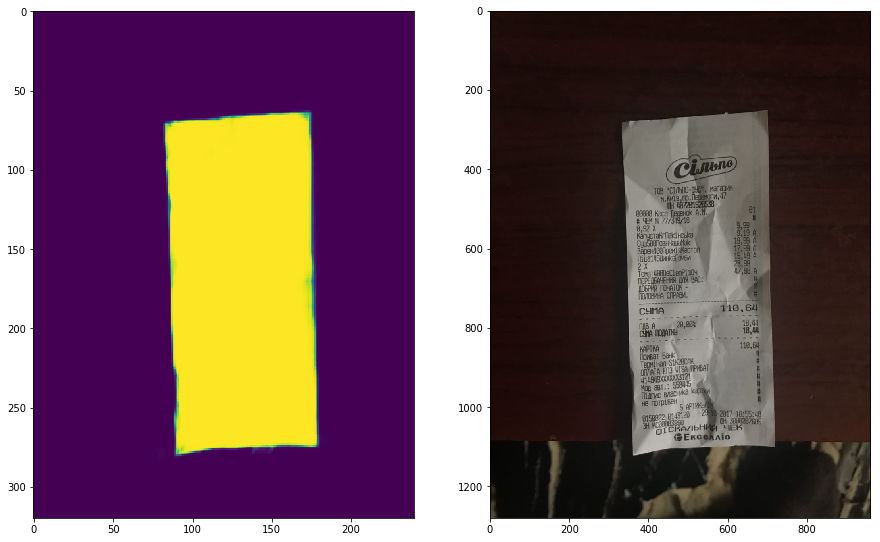

In [ ]:
i = i+1
f,ax = plt.subplots(1,2,figsize=(15,10))
ax[0].imshow(Y[i])
ax[1].imshow(X[i])

In [ ]:
for i in tqdm(range(len(X))):
    cv2.imwrite('./bills_cropped/bill_{}.jpg'.format(i), process(X[i],Y[i]))

 33%|███▎      | 56/169 [00:22<00:45,  2.47it/s]